# Indonesian Traffic Sign Detection - YOLOv8

Permorm augmentation on the dataset using rotation, night, and rain simulations.

[link to my dataset]()

In [11]:
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import random
import glob
from math import radians, sin, cos
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import shutil
import re

from ultralytics import YOLO

In [12]:
# ORIGINAL ----
#    Original dataset path
dataset_path = r'D:\Perkuliahan\Semester 8\Skripsi\development\ITSD Project\datasets\indonesian-traffic-sign-dataset' # PATH OF ORIGINAL FOLDER

#    Original images and labels path
ORIGINAL_IMAGES_PATH = os.path.join( dataset_path, 'images' ) 
ORIGINAL_LABELS_PATH = os.path.join( dataset_path, 'labels' )

#    Original train, valid, test path (CHECK THE FOLDER STRUCTURE)
ORIGINAL_TRAIN_IMAGES_PATH = os.path.join( ORIGINAL_IMAGES_PATH, 'train' )
ORIGINAL_TRAIN_LABELS_PATH = os.path.join( ORIGINAL_LABELS_PATH, 'train' )


# MODIFIED ----
#    Modified dataset path
modified_dataset_path = r'D:\Perkuliahan\Semester 8\Skripsi\development\ITSD Project\datasets\indonesian-traffic-sign-dataset-augmented' # PATH OF DESTINATION FOLDER
os.makedirs( modified_dataset_path, exist_ok=True )

#    Modified images and labels path
MODIFIED_IMAGES_PATH = os.path.join( modified_dataset_path, 'images' )
MODIFIED_LABELS_PATH = os.path.join( modified_dataset_path, 'labels' )
os.makedirs( MODIFIED_IMAGES_PATH, exist_ok=True )
os.makedirs( MODIFIED_LABELS_PATH, exist_ok=True )

#    Modified train, valid, test path
MODIFIED_TRAIN_IMAGES_PATH = os.path.join( MODIFIED_IMAGES_PATH, 'train' )
MODIFIED_TRAIN_LABELS_PATH = os.path.join( MODIFIED_LABELS_PATH, 'train' )
MODIFIED_VALID_IMAGES_PATH = os.path.join( MODIFIED_IMAGES_PATH, 'valid' )
MODIFIED_VALID_LABELS_PATH = os.path.join( MODIFIED_LABELS_PATH, 'valid' )
MODIFIED_TEST_IMAGES_PATH = os.path.join( MODIFIED_IMAGES_PATH, 'test' )
MODIFIED_TEST_LABELS_PATH = os.path.join( MODIFIED_LABELS_PATH, 'test' )
os.makedirs( MODIFIED_TRAIN_IMAGES_PATH, exist_ok=True )
os.makedirs( MODIFIED_TRAIN_LABELS_PATH, exist_ok=True )
os.makedirs( MODIFIED_VALID_IMAGES_PATH, exist_ok=True )
os.makedirs( MODIFIED_VALID_LABELS_PATH, exist_ok=True )
os.makedirs( MODIFIED_TEST_IMAGES_PATH, exist_ok=True )
os.makedirs( MODIFIED_TEST_LABELS_PATH, exist_ok=True )

In [13]:
# Check the number of images and labels in the original dataset
original_train_images = len( os.listdir( ORIGINAL_TRAIN_IMAGES_PATH ) )
original_train_labels = len( os.listdir( ORIGINAL_TRAIN_LABELS_PATH ) )


if original_train_images != original_train_labels:
    raise ValueError( f"The number of images and labels in the original dataset do not match. \nImages: {original_train_images} \nLabels: {original_train_labels}" )

print( f"Original train images: {original_train_images}" )
print( f"Original train labels: {original_train_labels}" )

Original train images: 2543
Original train labels: 2543


In [14]:
# Function to handle annotation value where the value is lower than 0 and higher than 1
def clamp( value, min_value=0.0, max_value=1.0 ):
    return max( min_value, min(value, max_value) )

# YOLO annotation reading function
def read_yolo_annotation( file_path: str ) -> list:
    annotations = []
    with open( file_path, 'r' ) as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int( parts[0] )
            cx, cy, w, h = map( float, parts[1:] )
            annotations.append( (class_id, cx, cy, w, h) )
    return annotations

# YOLO annotation saving function
def save_yolo_annotation( file_path: str, annotations: list ) -> None:
    with open( file_path, 'w' ) as f:
        for annotation in annotations:
            class_id, cx, cy, w, h = annotation
            f.write( f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n" )

In [15]:
# TEST FUNCTION - Function to draw YOLO bounding boxes on an image
def draw_yolo_bboxes( image_path: str, annotation_path: str ):
    image = cv2.imread( image_path )
    if image is None:
        print( f"🚨 Error: Unable to load image {image_path}" )
        return

    h, w, _ = image.shape  # Get image dimensions

    annotations = read_yolo_annotation( annotation_path )

    for annotation in annotations:
        class_id, cx, cy, bw, bh = annotation

        # Convert YOLO format to pixel coordinates
        x1 = int( (cx - bw / 2) * w )
        y1 = int( (cy - bh / 2) * h )
        x2 = int( (cx + bw / 2) * w )
        y2 = int( (cy + bh / 2) * h )

        # Draw bounding box
        cv2.rectangle( image, (x1, y1), (x2, y2), (0, 255, 0), 2 )
        cv2.putText( image, str(class_id), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2 )

    # Convert BGR to RGB for displaying
    image_rgb = cv2.cvtColor( image, cv2.COLOR_BGR2RGB )

    # Display the image
    plt.figure( figsize=(8, 6) )
    plt.imshow( image_rgb )
    plt.axis( "on" )
    plt.show()  

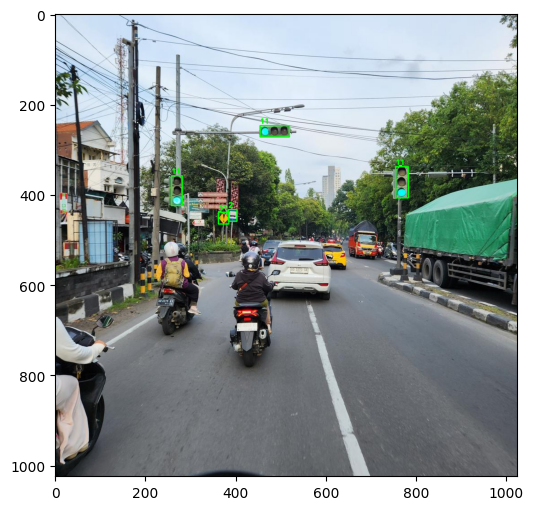

In [16]:
# Paths of images to show
path_image = ORIGINAL_TRAIN_IMAGES_PATH
path_label = ORIGINAL_TRAIN_LABELS_PATH
class_name = 'green light' # CHANGE THE CLASS NAME
image_number = 48 # CHANGE THE IMAGE NUMBER

image_path = os.path.join( path_image, f'{class_name} ({image_number}).jpg' )
label_path = os.path.join( path_label, f'{class_name} ({image_number}).txt' )

# Display images with bounding boxes
try:
    draw_yolo_bboxes( image_path, label_path )
except Exception as e:
    print( f"🚨 Error: {e}" )

In [17]:
# Function to rotate image and annotations
def rotate_image_and_annotations( image, annotations: list, angle: float ) -> tuple:
    # Get image dimensions
    ( h, w ) = image.shape[ :2 ]
    center = ( w / 2, h / 2 )

    # Convert angle to radians and compute sine and cosine values
    angle_rad = radians( angle )
    sin_angle, cos_angle = sin( angle_rad ), cos( angle_rad )

    # Calculate new canvas size
    new_w = int( abs(h * sin_angle) + abs(w * cos_angle) )
    new_h = int( abs(h * cos_angle) + abs(w * sin_angle) )

    # Create rotation matrix with additional translation
    matrix = cv2.getRotationMatrix2D( center, -angle, 1.0 )
    matrix[ 0, 2 ] += ( new_w - w ) / 2
    matrix[ 1, 2 ] += ( new_h - h ) / 2

    # Rotate image with new canvas size
    rotated_image = cv2.warpAffine( image, matrix, (new_w, new_h), flags=cv2.INTER_LINEAR )

    rotated_annotations = []
    for annotation in annotations:
        class_id, cx, cy, bw, bh = annotation
        cx_pixel, cy_pixel = cx * w, cy * h
        bw_pixel, bh_pixel = bw * w, bh * h

        # Calculate center point of bounding box after rotation
        new_cx_pixel = matrix[ 0, 0 ] * cx_pixel + matrix[ 0, 1 ] * cy_pixel + matrix[ 0, 2 ]
        new_cy_pixel = matrix[ 1, 0 ] * cx_pixel + matrix[ 1, 1 ] * cy_pixel + matrix[ 1, 2 ]

        # Calculate bounding box size after rotation
        new_bw_pixel = abs( bh_pixel * sin_angle ) + abs( bw_pixel * cos_angle )
        new_bh_pixel = abs( bh_pixel * cos_angle ) + abs( bw_pixel * sin_angle )

        # Normalize to original image size (not the new canvas)
        new_cx = clamp( new_cx_pixel / new_w * w / w )
        new_cy = clamp( new_cy_pixel / new_h * h / h )
        new_bw = clamp( new_bw_pixel / new_w * w / w )
        new_bh = clamp( new_bh_pixel / new_h * h / h )

        rotated_annotations.append( (class_id, new_cx, new_cy, new_bw, new_bh) )

    # Resize the rotated result back to original size
    resized_image = cv2.resize( rotated_image, (w, h) )

    return resized_image, rotated_annotations

# Function to apply night effect
def apply_night_effect( image, annotations, contrast_range=(-0.2, 0.2) ):
    angle = random.uniform( -6, 6 )
    rotated_image, rotated_annotations = rotate_image_and_annotations( image, annotations, angle )

    pil_img = Image.fromarray( cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB) )

    # Darken the image
    brightness_enhancer = ImageEnhance.Brightness( pil_img )
    darkened = brightness_enhancer.enhance( 0.5 )

    # Random contrast adjustment
    contrast_factor = 1 + np.random.uniform( contrast_range[0], contrast_range[1] )
    contrast_enhancer = ImageEnhance.Contrast( darkened )
    final_image = contrast_enhancer.enhance( contrast_factor )

    return cv2.cvtColor( np.array(final_image), cv2.COLOR_RGB2BGR ), rotated_annotations

# Function to apply rain effect
def apply_rain_effect( image, annotations, contrast_range=(-0.2, 0.2), brightness_range=(0.5, 1.0) ):
    # Add random rotation between -6 and 6 degrees
    angle = random.uniform( -6, 6 )
    rotated_image, rotated_annotations = rotate_image_and_annotations( image, annotations, angle )

    # Convert to PIL for brightness/contrast adjustment
    pil_img = Image.fromarray( cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB) )

    # Random brightness
    brightness_factor = random.uniform( *brightness_range )
    pil_img = ImageEnhance.Brightness( pil_img ).enhance( brightness_factor )

    # Random contrast
    contrast_factor = 1 + random.uniform( *contrast_range )
    pil_img = ImageEnhance.Contrast( pil_img ).enhance( contrast_factor )

    # Convert back to BGR format for OpenCV
    img = cv2.cvtColor( np.array(pil_img), cv2.COLOR_RGB2BGR )

    # Add rain effect
    rain_layer = np.zeros_like( img, dtype=np.uint8 )
    num_drops = random.randint( 500, 1000 )  # Light rain
    for _ in range( num_drops ):
        x = random.randint( 0, img.shape[1] - 1 )
        y = random.randint( 0, img.shape[0] - 1 )
        length = random.randint( 10, 30 )
        thickness = 1
        color = ( 200, 200, 200 )
        end_y = min( y + length, img.shape[0] - 1 )
        cv2.line( rain_layer, (x, y), (x, end_y), color, thickness )

    # Blend rain layer with original image
    blended = cv2.addWeighted( img, 1.0, rain_layer, 0.3, 0 )

    return blended, rotated_annotations

In [ ]:
# Check and create folder if it doesn't exist
def ensure_folder_exists( folder ):
    # Check if the folder exists, if not, create it
    if not os.path.exists( folder ):
        os.makedirs( folder )

# Function to augment the TRAIN dataset
def augment_dataset( original_image_folder, original_label_folder, output_image_folder, output_label_folder ):
    # Get the list of image paths in the original image folder
    image_paths = glob.glob( os.path.join(original_image_folder, "*.jpg") )

    # If no images found, print a message and return
    if not image_paths:
        print( "🚨 No images found for augmentation!" )
        return

    # Ensure output folders exist
    ensure_folder_exists( output_image_folder )
    ensure_folder_exists( output_label_folder )

    # Process each image in the original image folder
    for img_path in image_paths:
        # Extract the image name and corresponding label path
        img_name = os.path.basename( img_path )
        label_name = img_name.replace( ".jpg", ".txt" )
        label_path = os.path.join( original_label_folder, label_name )

        print( f"🔍 Processing: {img_name}" )

        # Copy the original image to the output folder if not already present
        dest_img = os.path.join( output_image_folder, img_name )
        if not os.path.exists( dest_img ):
            shutil.copy2( img_path, dest_img )
            print( f"✅ Original image copied: {img_name}" )

        # Copy the original label to the output folder if not already present
        dest_label = os.path.join( output_label_folder, label_name )
        if os.path.exists( label_path ):
            if not os.path.exists( dest_label ):
                shutil.copy2( label_path, dest_label )
                print( f"✅ Original label copied: {label_name}" )
        else:
            print( f"⚠ Label not found for {img_name}, skipping." )
            continue

        # Define output paths for augmented images and labels
        rotated_img_path = os.path.join( output_image_folder, img_name.replace(".jpg", "_augrotate.jpg") )
        rotated_label_path = os.path.join( output_label_folder, label_name.replace(".txt", "_augrotate.txt") )
        night_img_path = os.path.join( output_image_folder, img_name.replace(".jpg", "_augnight.jpg") )
        night_label_path = os.path.join( output_label_folder, label_name.replace(".txt", "_augnight.txt") )
        rain_img_path = os.path.join( output_image_folder, img_name.replace(".jpg", "_augrain.jpg") )
        rain_label_path = os.path.join( output_label_folder, label_name.replace(".txt", "_augrain.txt") )

        # Check if the augmented versions of the image and label already exist
        need_rotation = not ( os.path.exists(rotated_img_path) and os.path.exists(rotated_label_path) )
        need_night = not ( os.path.exists(night_img_path) and os.path.exists(night_label_path) )
        need_rain = not ( os.path.exists(rain_img_path) and os.path.exists(rain_label_path) )

        # If all augmented versions already exist, skip the augmentation
        if not need_rotation and not need_night and not need_rain:
            print( f"⏩ {img_name} already augmented, skipping." )
            continue

        # If augmentation is needed, process the image
        print( f"🛠 Performing augmentation on {img_name}..." )

        # Read the image and its corresponding annotations
        image = cv2.imread( img_path )
        annotations = read_yolo_annotation( label_path )

        # Apply rotation if needed
        if need_rotation:
            # Randomly choose an angle for rotation
            angle = random.uniform( -6, 6 )
            rotated_image, rotated_annotations = rotate_image_and_annotations( image, annotations, angle )
            cv2.imwrite( rotated_img_path, rotated_image )  # Save the rotated image
            save_yolo_annotation( rotated_label_path, rotated_annotations )  # Save the rotated label
            print( f"  🔄 Rotation {angle:.2f}° saved." )

        # Apply night effect if needed
        if need_night:
            night_image, night_annotations = apply_night_effect( image, annotations )
            cv2.imwrite( night_img_path, night_image )  # Save the night effect image
            save_yolo_annotation( night_label_path, night_annotations )  # Save the night effect label
            print( f"  🌙 Night effect saved." )
        
        # Apply rain effect if needed
        if need_rain:
            rain_image, rain_annotations = apply_rain_effect( image, annotations )
            cv2.imwrite( rain_img_path, rain_image )  # Save the rain effect image
            save_yolo_annotation( rain_label_path, rain_annotations )  # Save the rain effect label
            print( f"  🌧  Rain effect saved." )

In [ ]:
# Augmenting TRAIN dataset
augment_dataset(

    original_image_folder = ORIGINAL_TRAIN_IMAGES_PATH,
    original_label_folder = ORIGINAL_TRAIN_LABELS_PATH,
    output_image_folder   = MODIFIED_TRAIN_IMAGES_PATH,
    output_label_folder   = MODIFIED_TRAIN_LABELS_PATH

)

print( "\n✅ Train dataset augmentation completed." )

🔍 Processing: beware of pedestrians (10).jpg
⏩ beware of pedestrians (10).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (11).jpg
⏩ beware of pedestrians (11).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (12).jpg
⏩ beware of pedestrians (12).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (13).jpg
⏩ beware of pedestrians (13).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (14).jpg
⏩ beware of pedestrians (14).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (15).jpg
⏩ beware of pedestrians (15).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (17).jpg
⏩ beware of pedestrians (17).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (18).jpg
⏩ beware of pedestrians (18).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (19).jpg
⏩ beware of pedestrians (19).jpg already augmented, skipping.
🔍 Processing: beware of pedestrians (

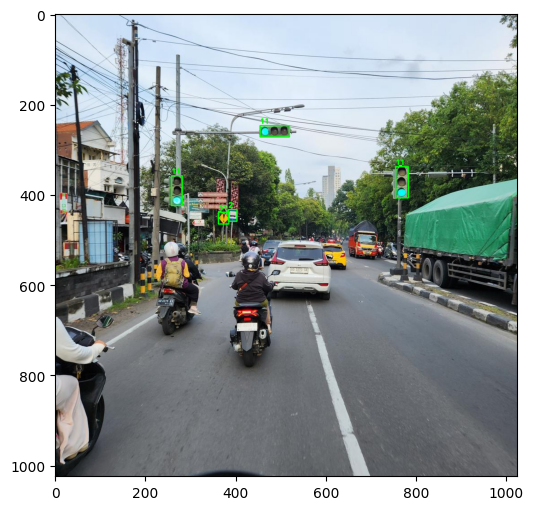

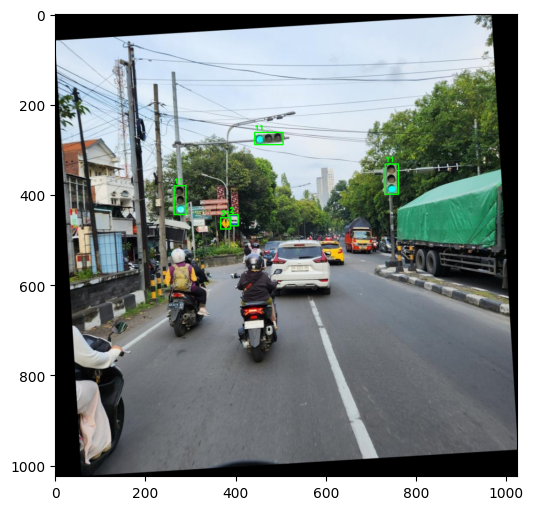

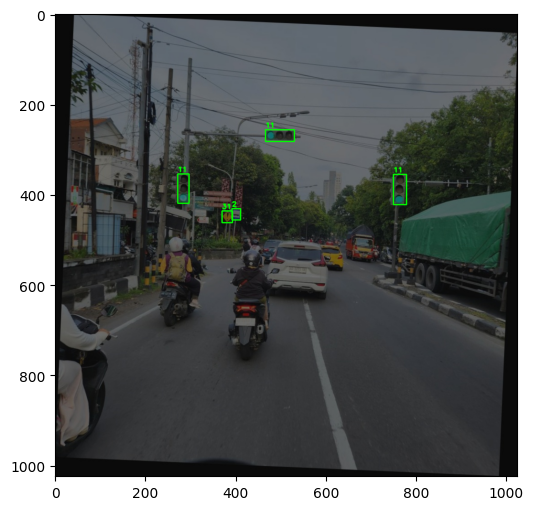

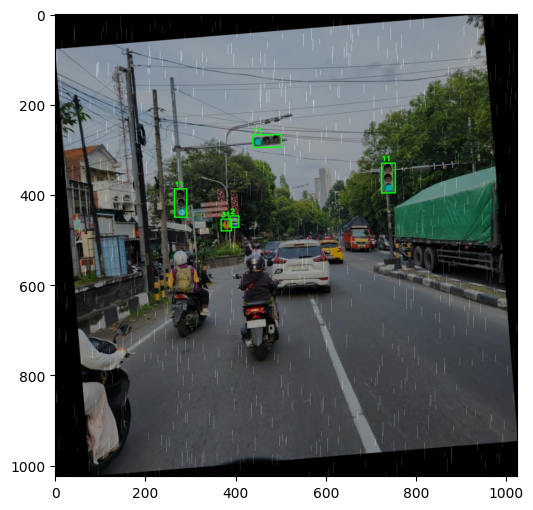

In [ ]:
# Paths to augmented images and labels
path_image = MODIFIED_TRAIN_IMAGES_PATH
path_label = MODIFIED_TRAIN_LABELS_PATH
class_name = 'green light' # Choose class name
image_number = 48 # Choose number

image_path = os.path.join( path_image, f'{class_name} ({image_number}).jpg' )
label_path = os.path.join( path_label, f'{class_name} ({image_number}).txt' )
image1_path = os.path.join( path_image, f'{class_name} ({image_number})_augrotate.jpg' )
label1_path = os.path.join( path_label, f'{class_name} ({image_number})_augrotate.txt' )
image2_path = os.path.join( path_image, f'{class_name} ({image_number})_augnight.jpg' )
label2_path = os.path.join( path_label, f'{class_name} ({image_number})_augnight.txt' )
image3_path = os.path.join( path_image, f'{class_name} ({image_number})_augrain.jpg' )
label3_path = os.path.join( path_label, f'{class_name} ({image_number})_augrain.txt' )

# Display images with bounding boxes
draw_yolo_bboxes( image_path, label_path )
draw_yolo_bboxes( image1_path, label1_path )
draw_yolo_bboxes( image2_path, label2_path )
draw_yolo_bboxes( image3_path, label3_path )

In [ ]:
# Check and create folder if it doesn't exist
def ensure_folder_exists( folder ):
    if not os.path.exists( folder ):
        os.makedirs( folder )

# Function to randomly augment the VALID and TEST dataset
def augment_dataset_gacha( original_image_folder, original_label_folder, output_image_folder, output_label_folder ):
    # Get all image paths with .jpg extension from the original image folder
    image_paths = glob.glob( os.path.join(original_image_folder, "*.jpg") )
    
    # Exit if no images found
    if not image_paths:
        print( "🚨 No images found for augmentation!" )
        return

    # Make sure output folders exist
    ensure_folder_exists( output_image_folder )
    ensure_folder_exists( output_label_folder )

    # Get all processed filenames (without augmentation suffixes)
    existing_files = [ os.path.basename(f) for f in glob.glob(os.path.join(output_image_folder, "*.jpg")) ]
    # Normalize: remove known suffixes to find original base names
    processed_basenames = set()
    for fname in existing_files:
        base = fname.replace( "_augrotate.jpg", "" ).replace( "_augnight.jpg", "" ).replace( "_augrain.jpg", "" ).replace( ".jpg", "" )
        processed_basenames.add( base )

    for img_path in image_paths:
        # Extract image and label file names
        img_name = os.path.basename( img_path )
        base_name = img_name.replace( ".jpg", "" )  # e.g., "image_001"
        label_name = img_name.replace( ".jpg", ".txt" )
        label_path = os.path.join( original_label_folder, label_name )

        # Skip if label file is missing
        if not os.path.exists( label_path ):
            print( f"⚠ Label not found for {img_name}, skipping." )
            continue

        # Skip if this base image name has already been processed
        if base_name in processed_basenames:
            print( f"⏩ {img_name} has already been augmented previously, skipping." )
            continue

        print( f"🎲 Gacha processing: {img_name}" )

        # Read the image and corresponding annotation
        image = cv2.imread( img_path )
        annotations = read_yolo_annotation( label_path )

        # Randomly choose one augmentation type: copy, rotate, night, or rain
        augmentation_type = random.choice( ['copy', 'rotate', 'night', 'rain'] )

        # Define file name suffix for each augmentation type
        suffix_map = {

            'copy': '',                # No suffix for original copy
            'rotate': '_augrotate',    # For rotated version
            'night': '_augnight',      # For night effect version
            'rain': '_augrain'         # For rain effect version

        }

        # Apply corresponding suffix to file names
        suffix = suffix_map[ augmentation_type ]
        out_img_name = img_name.replace( ".jpg", f"{suffix}.jpg" )
        out_label_name = label_name.replace( ".txt", f"{suffix}.txt" )

        # Define full output paths for image and label
        dest_img_path = os.path.join( output_image_folder, out_img_name )
        dest_label_path = os.path.join( output_label_folder, out_label_name )

        # Perform augmentation based on the selected type
        if augmentation_type == 'copy':
            shutil.copy2( img_path, dest_img_path )
            shutil.copy2( label_path, dest_label_path )
            print( f"  📁 Copied original image and label: {out_img_name}" )

        elif augmentation_type == 'rotate':
            angle = random.uniform( -6, 6 )
            rotated_img, rotated_ann = rotate_image_and_annotations( image, annotations, angle )
            cv2.imwrite( dest_img_path, rotated_img )
            save_yolo_annotation( dest_label_path, rotated_ann )
            print( f"  🔄 Rotated {angle:.2f}° saved: {out_img_name}" )

        elif augmentation_type == 'night':
            night_img, night_ann = apply_night_effect( image, annotations )
            cv2.imwrite( dest_img_path, night_img )
            save_yolo_annotation( dest_label_path, night_ann )
            print( f"  🌙 Night effect saved: {out_img_name}" )

        elif augmentation_type == 'rain':
            rain_img, rain_ann = apply_rain_effect( image, annotations )
            cv2.imwrite( dest_img_path, rain_img )
            save_yolo_annotation( dest_label_path, rain_ann )
            print( f"  🌧  Rain effect saved: {out_img_name}" )

In [ ]:
# Augmenting VALID dataset
augment_dataset_gacha(

    original_image_folder = ORIGINAL_TRAIN_IMAGES_PATH,
    original_label_folder = ORIGINAL_TRAIN_LABELS_PATH,
    output_image_folder   = MODIFIED_VALID_IMAGES_PATH,
    output_label_folder   = MODIFIED_VALID_LABELS_PATH

)

print( "\n✅ Valid dataset augmentation completed." )

⏩ beware of pedestrians (10).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (11).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (12).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (13).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (14).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (15).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (17).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (18).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (19).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (2).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (20).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (21).jpg has already been augmented previously, skipping.
⏩ beware of pedes

🖼 Display the result: green light (43).jpg


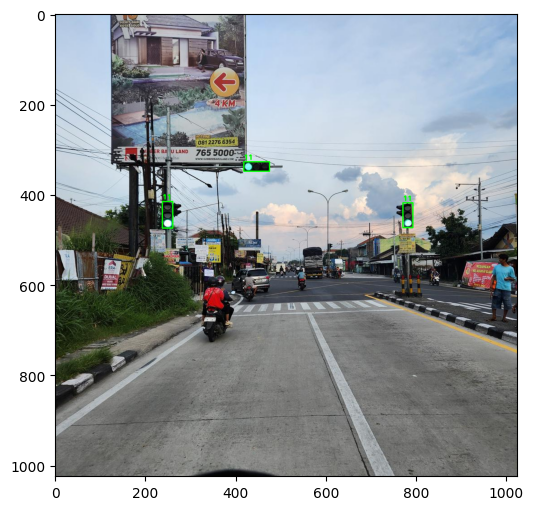

In [ ]:
# Paths to augmented images and labels
path_image = MODIFIED_VALID_IMAGES_PATH
path_label = MODIFIED_VALID_LABELS_PATH
class_name = 'green light'
image_number = 43

# Build base file name
base_name = f"{ class_name } ({ image_number })"

# Define all possible suffixes (including original)
suffixes = [ '', '_augrotate', '_augnight', '_augrain' ]

# Try to find and display all existing versions
for suffix in suffixes:
    img_filename = f"{ base_name }{ suffix }.jpg"
    label_filename = f"{ base_name }{ suffix }.txt"

    img_path = os.path.join( path_image, img_filename )
    label_path = os.path.join( path_label, label_filename )

    if os.path.exists( img_path ) and os.path.exists( label_path ):
        print( f"🖼 Display the result: {img_filename}" )
        try:
            draw_yolo_bboxes( img_path, label_path )
        except Exception as e:
            print( f"🚨 Failed to display: {img_filename}: {e}" )

In [ ]:
# Augmenting TEST dataset
augment_dataset_gacha(

    original_image_folder = ORIGINAL_TRAIN_IMAGES_PATH,
    original_label_folder = ORIGINAL_TRAIN_LABELS_PATH,
    output_image_folder   = MODIFIED_TEST_IMAGES_PATH,
    output_label_folder   = MODIFIED_TEST_LABELS_PATH

)

print( "\n✅ Test dataset augmentation completed." )

⏩ beware of pedestrians (10).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (11).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (12).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (13).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (14).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (15).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (17).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (18).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (19).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (2).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (20).jpg has already been augmented previously, skipping.
⏩ beware of pedestrians (21).jpg has already been augmented previously, skipping.
⏩ beware of pedes

🖼 Display the result: green light (36)_augrain.jpg


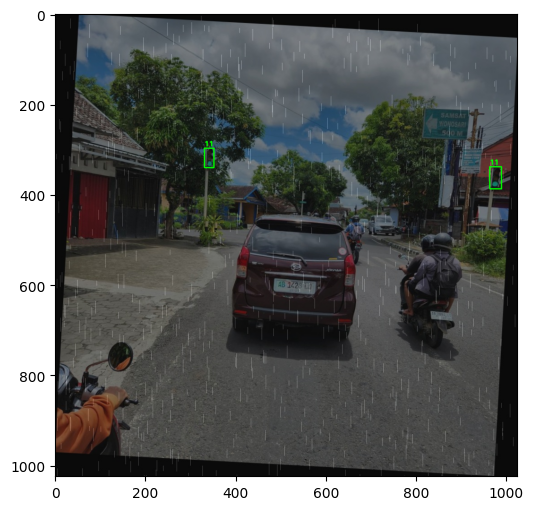

In [60]:
# Paths to augmented images and labels
path_image = MODIFIED_TEST_IMAGES_PATH
path_label = MODIFIED_TEST_LABELS_PATH
class_name = 'green light'
image_number = 36

# Build base file name
base_name = f"{ class_name } ({ image_number })"

# Define all possible suffixes (including original)
suffixes = [ '', '_augrotate', '_augnight', '_augrain' ]

# Try to find and display all existing versions
for suffix in suffixes:
    img_filename = f"{ base_name }{ suffix }.jpg"
    label_filename = f"{ base_name }{ suffix }.txt"

    img_path = os.path.join( path_image, img_filename )
    label_path = os.path.join( path_label, label_filename )

    if os.path.exists( img_path ) and os.path.exists( label_path ):
        print( f"🖼 Display the result: {img_filename}" )
        try:
            draw_yolo_bboxes( img_path, label_path )
        except Exception as e:
            print( f"🚨 Failed to display: {img_filename}: {e}" )

In [ ]:
# Check the number of images and labels in the modified dataset
modified_train_images = len( os.listdir( MODIFIED_TRAIN_IMAGES_PATH ) )
modified_train_labels = len( os.listdir( MODIFIED_TRAIN_LABELS_PATH ) )
modified_valid_images = len( os.listdir( MODIFIED_VALID_IMAGES_PATH ) )
modified_valid_labels = len( os.listdir( MODIFIED_VALID_LABELS_PATH ) )
modified_test_images = len( os.listdir( MODIFIED_TEST_IMAGES_PATH ) )
modified_test_labels = len( os.listdir( MODIFIED_TEST_LABELS_PATH ) )

if modified_train_images != modified_train_labels and modified_valid_images != modified_valid_labels and modified_test_images != modified_test_labels:
    raise ValueError(

        f"The number of images and labels in the original dataset do not match.",
        f"\nTrain Images: { modified_train_images } \nTrain Labels: { modified_train_labels }",
        f"\nValid Images: { modified_valid_images } \nValid Labels: { modified_valid_labels }",
        f"\nTest Images: { modified_test_images } \nTest Labels: { modified_test_labels }"

    )

print(

    f"Train images: { modified_train_images }",
    f"\nTrain labels: { modified_train_labels }",
    f"\nValid images: { modified_valid_images }",
    f"\nValid labels: { modified_valid_labels }",
    f"\nTest images: { modified_test_images }",
    f"\nTest labels: { modified_test_labels }"
    
)

Train images: 10172 
Train labels: 10172 
Valid images: 2543 
Valid labels: 2543 
Test images: 2543 
Test labels: 2543
